In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

In [3]:
config_name = 'propagation'
conf = load_conf(config_name)

In [4]:
# Contains tuple of:
# - params
# - data_pot
# - data_psi2[ |Φ|, Re{Φ}, Im{Φ} ]
# - data_obs[t, prob, prob, E, xmoy, x2moy, pmoy, p2moy]
dataset = run_with_params(
    config_name,
    [{}]
)
params, data_pot, data_psi2, data_obs = dataset[0]
x = data_pot[:,0]
t = data_obs[:,0]
H_moy = data_obs[:,3]
x_moy = data_obs[:,4]
x2_moy = data_obs[:,5]
p_moy = data_obs[:,6]
p2_moy = data_obs[:,7]

delta_x = np.sqrt(x2_moy - x_moy**2)
delta_p = np.sqrt(p2_moy - p_moy**2)

Running simulations... Done 1/1


# Plots!

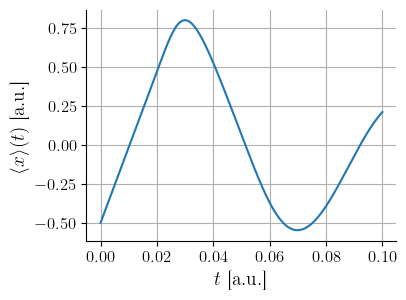

In [5]:
%matplotlib inline
plt.plot(t, x_moy, label=r"$\langle x \rangle$")
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle x \rangle(t)$ [a.u.]')
# plt.legend()
plt.grid()
plt.savefig(export_path + 'i_xmoy.pdf')

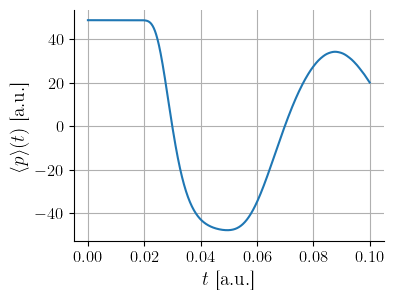

In [6]:
%matplotlib inline
plt.plot(t, p_moy, label=r"$\langle p \rangle$")
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle p \rangle(t)$ [a.u.]')
# plt.legend()
plt.grid()
plt.savefig(export_path + 'i_pmoy.pdf')

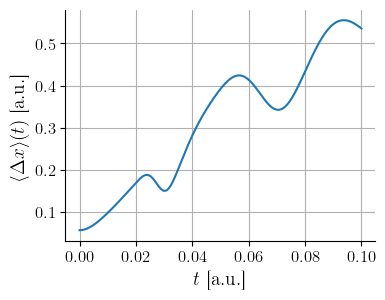

In [7]:
%matplotlib inline
plt.plot(t, delta_x, label=r"$\langle \Delta x \rangle$")
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle \Delta x \rangle(t)$ [a.u.]')
# plt.legend()
plt.grid()
plt.savefig(export_path + 'i_deltax.pdf')

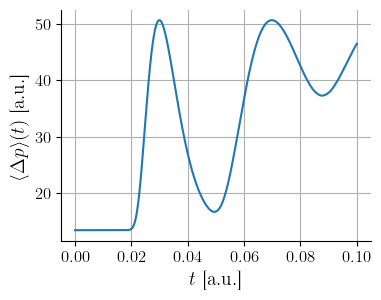

In [8]:
%matplotlib inline
plt.plot(t, delta_p, label=r"$\langle \Delta p \rangle$")
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle \Delta p \rangle(t)$ [a.u.]')
# plt.legend()
plt.grid()
plt.savefig(export_path + 'i_deltap.pdf')

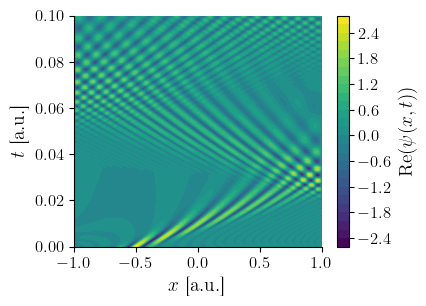

In [19]:
%matplotlib inline
X, Y = np.meshgrid(x, t)
plt.contourf(X, Y, data_psi2[:,1::3], levels=32)
plt.colorbar().set_label(r'$\mathrm{Re}(\psi(x,t))$')
plt.xlabel(r'$x$ [a.u.]')
plt.ylabel(r'$t$ [a.u.]')
# plt.legend()
# plt.grid()
# vitesse de phase plus élevée que la vitesse de groupe => milieu dispersif
# vitesse augmente (?) près des bords, puis redescend apres le rebond,
# puis recommence a augmenter
plt.savefig(export_path + 'i_repsi.png')

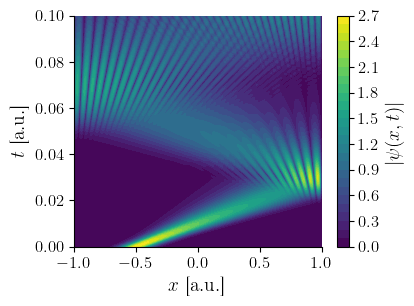

In [10]:
%matplotlib inline
X, Y = np.meshgrid(x, t)
plt.contourf(X, Y, np.sqrt(data_psi2[:,::3]), levels=32)
plt.colorbar().set_label(r'$|\psi(x,t)|$')
plt.xlabel(r'$x$ [a.u.]')
plt.ylabel(r'$t$ [a.u.]')
# plt.legend()
# plt.grid()
plt.savefig(export_path + 'i_normpsi.png')

## Comparaison avec particule classique

Energy $$E = p²/2m$$
Because $m=1$, $p=v$ and
$$\implies p = \pm \sqrt{2E}$$
we take positive solution to have the same direction as quantum particle

In [11]:
def do_classical_sim(energy: float = None, momentum: float = None) -> np.ndarray:
    if energy is not None:
        v0 = np.sqrt(2 * energy)
    elif momentum is not None:
        v0 = momentum
    else:
        raise ValueError('No energy or momentum provided!')
    N = int(conf['tfin'] / conf['dt'])
    pos = np.zeros(N + 1)
    pos[0] = conf['x0']
    for i in range(1, N+1):
        # quick and dirty even though we have explicit solutions
        # should actually give the correct result, within floating point accuracy
        pos[i] = pos[i-1] + v0*conf['dt']
        if pos[i] >= conf['xR']:
            v0 *= -1
            pos[i] -= 2 * (pos[i] - conf['xR'])
        if pos[i] <= conf['xL']:
            v0 *= -1
            pos[i] += 2 * (conf['xL'] - pos[i])
    return pos

V0 = 1283.2037962506


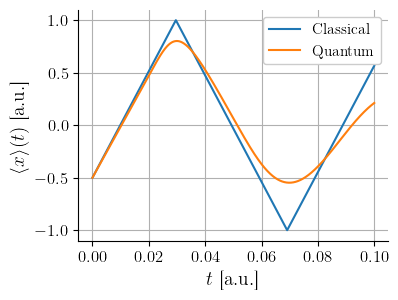

In [12]:
x_classical = do_classical_sim(energy=H_moy[0])
print(f'V0 = {H_moy[0]}')
plt.plot(t, x_classical, label=r'Classical')

plt.plot(t, x_moy, label=r"Quantum")
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle x \rangle(t)$ [a.u.]')
plt.legend()
plt.grid()
plt.savefig(export_path + 'i_classical_vs_quantum_energy.pdf')

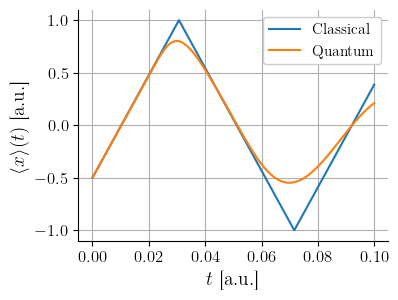

In [13]:
x_classical = do_classical_sim(momentum=p_moy[0])
plt.plot(t, x_classical, label=r'Classical')

plt.plot(t, x_moy, label=r"Quantum")
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle x \rangle(t)$ [a.u.]')
plt.legend()
plt.grid()
plt.savefig(export_path + 'i_classical_vs_quantum_momentum.pdf')

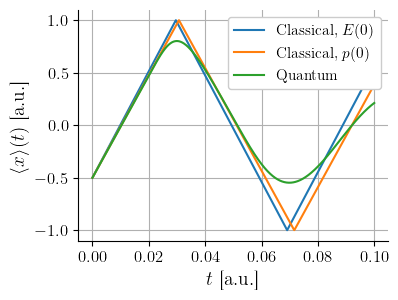

In [14]:
x_classical1 = do_classical_sim(energy=H_moy[0])
x_classical2 = do_classical_sim(momentum=p_moy[0])
plt.plot(t, x_classical1, label=r'Classical, $E(0)$')
plt.plot(t, x_classical2, label=r'Classical, $p(0)$')

plt.plot(t, x_moy, label=r"Quantum")
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle x \rangle(t)$ [a.u.]')
plt.legend()
plt.grid()
# plt.savefig(export_path + 'i_classical_vs_quantum_energy.pdf')

## Conservation

Error on conservation of probability: 1.8696155734687636e-13


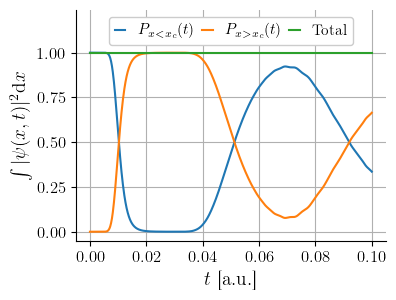

In [15]:
%matplotlib inline

plt.plot(data_obs[:,0], data_obs[:,1], label=r"$P_{x<x_c}(t)$")
plt.plot(data_obs[:,0], data_obs[:,2], label=r"$P_{x>x_c}(t)$")
total = data_obs[:,1] + data_obs[:,2]
plt.plot(data_obs[:,0], total, label="Total")

print(f'Error on conservation of probability: {np.max(total) - np.min(total)}')

plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\int |\psi(x,t)|^2 \mathrm{d}x$')
plt.ylim(plt.ylim()[0], 1.24)
plt.legend(ncols=3, columnspacing=0.5, handlelength=0.7, loc='upper center')
plt.grid()
plt.savefig(export_path + 'i_conservation_probability.pdf')

Error on conservation of energy: 2.398792275926098e-10


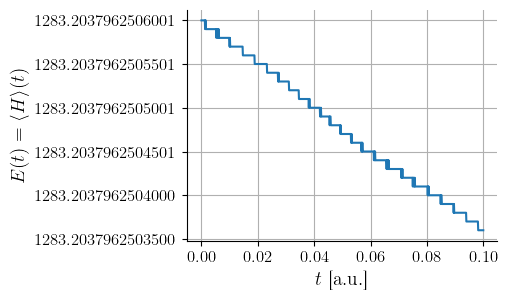

In [16]:
%matplotlib inline
plt.plot(data_obs[:,0], H_moy, label="NRJ its music only")

print(f'Error on conservation of energy: {np.max(H_moy) - np.min(H_moy)}')

plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$E(t) = \langle H \rangle (t)$')
# plt.legend()
plt.grid()
plt.savefig(export_path + 'i_conservation_energy.pdf')

Minimum distance: 0.25565124408531426


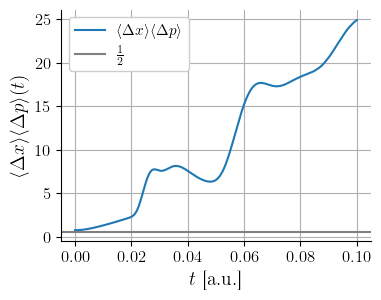

In [17]:
%matplotlib inline
plt.plot(t, delta_x*delta_p, label=r'$\langle \Delta x \rangle \langle \Delta p \rangle$')

print(f'Minimum distance: {np.min(delta_x * delta_p) - 1/2}')

plt.axhline(1/2, label=r'$\frac{1}{2}$')
plt.xlabel(r'$t$ [a.u.]')
plt.ylabel(r'$\langle \Delta x \rangle \langle \Delta p \rangle (t)$')
plt.legend()
plt.grid()
plt.savefig(export_path + 'i_heisenberg.pdf')